In [1]:
from os import walk 
from os.path import join
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

import nltk 
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import sys
print(sys.executable)

C:\Users\HP\anaconda3\python.exe


In [3]:
eg = "./01_Processing/practice_email.txt"
PATH1 = './01_Processing/spam_assassin_corpus/spam_1'
PATH2 = './01_Processing/spam_assassin_corpus/spam_2'
PATH3 = './01_Processing/spam_assassin_corpus/easy_ham_1'
PATH4 = './01_Processing/spam_assassin_corpus/easy_ham_2'
DATA_JSON_FILE = './01_Processing/email-text-data.json'
WORD_ID_FILE = './01_Processing/word-by-id.csv'
TRAINING_DATA_FILE = './02_Training/train-data.txt'
TEST_DATA_FILE = './03_Testing/test-data.txt'

In [4]:
stream = open(eg, encoding='latin-1')
msg = stream.read()
stream.close()
print(msg)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
import sys 
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(eg, encoding='latin-1')
lines = []
is_body = False
for i in stream:
    if is_body:
        lines.append(i)
    elif i == '\n':
        is_body = True
stream.close()

body = '\n'.join(lines)
print(body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Function

In [7]:
def gen(no):
    for i in range (no):
        yield i ** 2
gen(5)

<generator object gen at 0x0000023844BE36D0>

In [8]:
for i in gen(5):
    print(i, end=' ')

0 1 4 9 16 

# Email Body Extraction

In [9]:
def email_body(path):
    for root, dir, file in walk(path):
        for name in file:
            filepath = join(root, name)
            stream = open(filepath, encoding='latin-1')
            lines = []
            is_body = False
            for i in stream:
                if is_body:
                    lines.append(i)
                elif i == '\n':
                    is_body = True
            stream.close()

            body = '\n'.join(lines)
            yield name, body

In [10]:
def df_from_dir(path, classification):
    rows = []
    row_names = []
    for file_name, body in email_body(path):
        rows.append({'MESSAGE': body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_dir(PATH1, 1)
spam_emails = spam_emails.append(df_from_dir(PATH2, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_dir(PATH3, 0)
ham_emails = ham_emails.append(df_from_dir(PATH4, 0))
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
data.shape

(5799, 2)

In [15]:
data['MESSAGE'].isnull().sum()

0

In [16]:
(data['MESSAGE'].str.len() == 0).sum()

3

In [17]:
data[(data['MESSAGE'].str.len() == 0)].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [18]:
data.index.get_loc('01400.b444b69845db2fa0a4693ca04e6ac5c5')

1896

In [19]:
data[1896:1897]

,MESSAGE,CATEGORY
01400.b444b69845db2fa0a4693ca04e6ac5c5,ATTN:SIR/MADAN \n\n\n\n ...,1


In [20]:
data.drop(['cmds'], inplace=True)

In [21]:
data.shape

(5796, 2)

In [22]:
doc_ids = range(0, len(data.index))
data['DOC_ID'] = doc_ids
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int32

In [23]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [24]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# JSON File

In [25]:
#data.to_json(DATA_JSON_FILE)

# Visualization (Pie Chart)

In [26]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [27]:
No_of_spam = data.CATEGORY.value_counts()[1]
No_of_ham = data.CATEGORY.value_counts()[0]

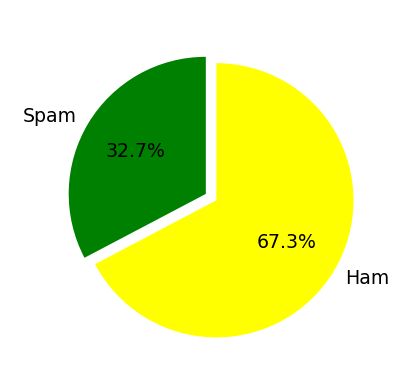

In [28]:
category = ['Spam', 'Ham']
sizes = [No_of_spam, No_of_ham]
my_colors = ['green', 'yellow']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category, textprops={'fontsize': 6}, startangle=90, explode=[0, 0.09], 
        autopct='%1.1f%%', colors=my_colors)
plt.show()

# Donut Chart

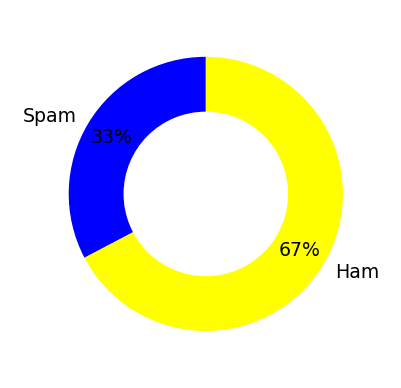

In [29]:
category = ['Spam', 'Ham']
sizes = [No_of_spam, No_of_ham]
my_colors = ['blue', 'yellow']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=my_colors, pctdistance=0.8)

my_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(my_circle)
plt.show()

# Multiple Categories

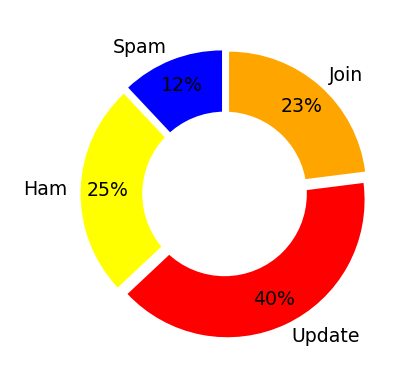

In [30]:
category = ['Spam', 'Ham', 'Update', 'Join']
sizes = [12, 25, 40, 23]
my_colors = ['blue', 'yellow', 'red', 'orange']
offset = [0.05, 0.05, 0.05, 0.05]
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=my_colors, 
        explode=offset, pctdistance=0.8)

my_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(my_circle)
plt.show()

# Natural Language Processing 

In [31]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     certificate signature failure (_ssl.c:1125)>


False

## 1) Tokenising

In [32]:
msg = 'Nishad Prasanna Kanago'
word_tokenize(msg.lower())

['nishad', 'prasanna', 'kanago']

## 2) Stop Words

In [33]:
stop_words = set(stopwords.words('english'))
if 'this' in stop_words: print("cool")

cool


In [34]:
str = 'Nishad iS A gOOd boY !'
tw = word_tokenize(str.lower())
filtered_list = []
for i in tw:
    if i not in stop_words:
        filtered_list.append(i);
filtered_list

['nishad', 'good', 'boy', '!']

## 3) Stemming and remove Punctuations

In [35]:
str = 'Getting an ice creamed flavoured chocolate ? is indeed the most ruined choise . I have ever seen so far !'
tw = word_tokenize(str.lower())
filtered_list = []
# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

for i in tw:
    if i not in stop_words and i.isalpha():
        stemmed_word = stemmer.stem(i)
        filtered_list.append(stemmed_word);
filtered_list

['get',
 'ice',
 'cream',
 'flavour',
 'chocol',
 'inde',
 'ruin',
 'chois',
 'ever',
 'seen',
 'far']

## 4) Removing HTML tags

In [36]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
  <!-- End Calypso -->
  <!-- Inserted by Calypso=

 -->
  <font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
   <br/>
  </font>
  &lt;=

/TR&gt;
  <!-- End Calypso -->
  <font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
   <center>
    Save up to 70% o

In [37]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

## 5) Cleaning and Preocessing Emails

In [38]:
def clean_msg(message, stop_word_set = set(stopwords.words('english')), stemmer = SnowballStemmer('english')):
    soup1 = BeautifulSoup(message, 'html.parser')
    new = soup1.get_text()
    filter_word = []
    email_tok = word_tokenize(new.lower())
    for j in email_tok:
        if j not in stop_word_set and j.isalpha():
            filter_word.append(stemmer.stem(j))
    return filter_word 

In [39]:
clean_msg(data.at[0, 'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'kes',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

# Cleaning and tokenization 

# Sclicing dataframe

In [40]:
data.iat[2, 2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [41]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_msg)

In [42]:
flat_list = [j for i in nested_list for j in i]
len(flat_list)

192

# Cleaning all data 

In [43]:
%%time 
nest_msg = data.MESSAGE.apply(clean_msg)

C:\Users\HP\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 1min 21s


In [44]:
nest_msg.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

# Logic to create subsets of dataframe

In [45]:
data[data.CATEGORY == 1].head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [46]:
id_spam = data[data.CATEGORY == 1].index 
id_ham = data[data.CATEGORY == 0].index 

In [47]:
nested_ham = nest_msg.loc[id_ham]
nested_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [48]:
nested_spam = nest_msg.loc[id_spam]
nested_spam.tail()

DOC_ID
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strict, confidenti, pleas, introduc, na...
Name: MESSAGE, dtype: object

In [49]:
flat_ham_list = [j for i in nested_ham for j in i]
normal_words = pd.Series(flat_ham_list).value_counts()

normal_words.shape[0]           # number of unique words in ham

20704

In [50]:
normal_words.head()

http    6609
use     3633
list    2880
one     2373
get     2286
dtype: int64

In [51]:
flat_spam_list = [j for i in nested_spam for j in i]
spam_words = pd.Series(flat_spam_list).value_counts()

print(spam_words.shape[0])   # number of unique words in ham
spam_words[:10]

13186


email     3090
http      2902
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Word Cloud

In [52]:
# nltk.download('stopwords')
# nltk.download('gutenberg')
# nltk.download('shakespeare')
# example_corpus = nltk.corpus.gutenberg.words(r"C:\Users\HP\AppData\Roaming\nltk_data\corpora\gutenberg\melville-moby_dick.txt")
# len(example_corpus)
# word_list = [''.join(word) for word in example_corpus]
# novel_as_string = ' '.join(word_list)

# word_cloud = WordCloud().generate(novel_as_string)
# plt.imshow(word_cloud)
# plt.axis('off')
# plt.show()

# Vocabulary Dataframe

In [53]:
word_id = list(range(0, 2500))
vocab = pd.DataFrame({'Vocab_word': normal_words[:2500].index.values}, index = word_id)
vocab.index.name = 'WORD_ID'
vocab

,Vocab_word
WORD_ID,
0,http
1,use
2,list
3,one
4,get
...,...
2495,tonight
2496,codec
2497,tini


# Save data as .csv

In [54]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.Vocab_word.name)

In [55]:
'learn' in set(vocab.Vocab_word)

True

In [56]:
email_length = [len(i) for i in nest_msg]
print(max(email_length))
np.argmax(email_length)

7671


5775

In [57]:
data.at[5775, 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Sparse Matrix

In [58]:
word_index = pd.Index(vocab.Vocab_word)
type(word_index[3])
word_index

Index(['http', 'use', 'list', 'one', 'get', 'mail', 'would', 'like', 'messag',
       'work',
       ...
       'eirikur', 'q', 'garym', 'bullet', 'canarsi', 'tonight', 'codec',
       'tini', 'centr', 'council'],
      dtype='object', name='Vocab_word', length=2500)

In [59]:
type(nest_msg.tolist())

list

In [60]:
word_df = pd.DataFrame.from_records(nest_msg.tolist())
word_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lbs,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lbs,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lbs,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


# Split train  and test set

In [61]:
X_train, X_test, y_train, y_test = train_test_split(word_df, data.CATEGORY, test_size=0.3, random_state=42)

In [62]:
X_train.index.name = X_test.index.name = 'DOC_ID'
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [63]:
def make_sparce_matrix(df, indexed_words, labels):
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    for i in range (nr_rows):
        for j in range (nr_cols):
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

# Combine occurances for training data

In [64]:
# %%time 
# sparce_train_df = make_sparce_matrix(X_train, word_index, y_train) 

In [65]:
train_grouped = sparce_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum() 
train_grouped.head()

NameError: name 'sparce_train_df' is not defined

In [ ]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

In [ ]:
print(vocab.at[4, 'Vocab_word'])
data.MESSAGE[4]

In [ ]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

# Combine occurances for testing data

In [ ]:
# %%time 
# sparce_test_df = make_sparce_matrix(X_test, word_index, y_test)

In [ ]:
test_grouped = sparce_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

In [ ]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')